#### Chain Of Thoughts With RAG
What is Chain-of-Thought (CoT) in RAG?

CoT reasoning breaks down a complex question into intermediate reasoning steps, and allows retrieval + reflection at each step before answering.

User Query
   ↓
- Step 1: Decompose question → sub-steps (Reason) => Note: they are not sub - questions but reasoning step-by-step
- Step 2: Retrieve docs per step (Act)
- Step 3: Combine context (Observe)
- Step 4: Final answer generation (Reflect)

In [2]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END

/Users/maruthienugula/RAG_learnings/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# -------------------------------
# 1. Prepare Vectorstore
# -------------------------------
docs = TextLoader("research-notes.txt",encoding="utf-8").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
from langchain_huggingface import HuggingFaceEmbeddings

# Intializing a simple Hugging face model without any api key
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [5]:
from langchain.chat_models import init_chat_model
import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = init_chat_model("groq:openai/gpt-oss-20b")

In [6]:
# -------------------------------
# 2. LangGraph State Definition
# -------------------------------
class RAGCoTState(BaseModel):
    question: str
    sub_steps: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [21]:
# -------------------------------
# 3. Nodes
# -------------------------------

# a. Plan sub-questions
def plan_steps(state:RAGCoTState)->RAGCoTState:
    prompt=f"Break the question into 2-3 reasoning steps Don't reply with any other things just break them and reply with the broken steps: \n\n {state.question}"
    result=llm.invoke(prompt).content
    subqs=[line.strip("- ") for line in result.split("\n") if line.strip()]

    return state.model_copy(update={"sub_steps":subqs}) # model_copy -> takes subqs and copy them into sub_steps : something like super class insertion

In [20]:
query = "what are the additional experiments in Transformer eveluation?" #just an example from research-notes.txt which is a company's notes example
state = RAGCoTState(question=query)
planned_steps_example = plan_steps(state=state)
planned_steps_example

RAGCoTState(question='what are the additional experiments in Transformer eveluation?', sub_steps=['1. Identify the core question: what additional experiments are performed in Transformer evaluation?', '2. Enumerate the types of experiments beyond standard benchmarks (e.g., ablation studies, hyper‑parameter sweeps, robustness tests, efficiency metrics, transfer‑learning tests, interpretability experiments).', '3. Summarize the categories and specific experiments that are commonly reported in the literature.'], retrieved_docs=[], answer='')

In [22]:
# b. Retrieve for each step
def retrieve_per_step(state:RAGCoTState)-> RAGCoTState:
    all_docs=[]
    for sub in state.sub_steps:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})

In [23]:
# c. Generate Final Answer
def generate_answer(state: RAGCoTState) -> RAGCoTState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
You are answering a complex question using reasoning and retrieved documents.

Question: {state.question}

Relevant Information:
{context}

Now synthesize a well-reasoned final answer.
"""
    result = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": result})

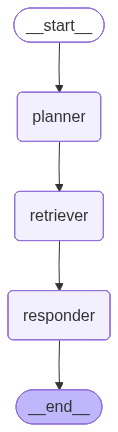

In [24]:
# -------------------------------
# 4. LangGraph Graph
# -------------------------------
builder = StateGraph(RAGCoTState)
builder.add_node("planner", plan_steps)
builder.add_node("retriever", retrieve_per_step)
builder.add_node("responder", generate_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [25]:
# -------------------------------
# 5. Run CoT RAG Agent
# -------------------------------
from IPython.display import display, Markdown
if __name__ == "__main__":
    query = "what are the additional experiments in Transformer eveluation?" #just an example from research-notes.txt which is a company's notes example
    state = RAGCoTState(question=query)
    final = graph.invoke(state)

    print("\n Reasoning Steps:",final['sub_steps'])
    #display(Markdown(final['sub_steps']))
    print("\n Final Answer:\n",final['answer'])
    #display(Markdown(final['answer']))


 Reasoning Steps: ['1. Clarify the core evaluation metrics and tasks commonly used for Transformers (e.g., perplexity, accuracy, BLEU).', '2. Identify what is meant by “additional experiments”—i.e., tests beyond the standard metrics, such as ablation studies, robustness checks, or resource efficiency analyses.', '3. Enumerate the specific additional experiments that are typically performed in Transformer evaluation (e.g., layer-wise analysis, attention visualization, adversarial robustness, cross‑domain transfer, hardware profiling).']

 Final Answer:
 **Additional Experiments in the Transformer Evaluation (July 2024)**  

| # | Experiment | What was tested | Key take‑aways |
|---|------------|-----------------|----------------|
| **1** | **FlashAttention‑2 integration** | Integrated the FlashAttention‑2 kernel into LLaMA‑2 to accelerate the self‑attention operation. | Latency on long‑context inputs dropped by ~50 % while keeping the same throughput; no accuracy loss. |
| **2** | **Ch

In [26]:
md_text = "\n\n".join(final["sub_steps"])
display(Markdown(md_text))




1. Clarify the core evaluation metrics and tasks commonly used for Transformers (e.g., perplexity, accuracy, BLEU).

2. Identify what is meant by “additional experiments”—i.e., tests beyond the standard metrics, such as ablation studies, robustness checks, or resource efficiency analyses.

3. Enumerate the specific additional experiments that are typically performed in Transformer evaluation (e.g., layer-wise analysis, attention visualization, adversarial robustness, cross‑domain transfer, hardware profiling).

In [27]:
display(Markdown(final['answer']))

**Additional Experiments in the Transformer Evaluation (July 2024)**  

| # | Experiment | What was tested | Key take‑aways |
|---|------------|-----------------|----------------|
| **1** | **FlashAttention‑2 integration** | Integrated the FlashAttention‑2 kernel into LLaMA‑2 to accelerate the self‑attention operation. | Latency on long‑context inputs dropped by ~50 % while keeping the same throughput; no accuracy loss. |
| **2** | **Chain‑of‑Thought (CoT) prompting** | Compared direct‑answer prompting with CoT and reflective prompting on a suite of logic and math problems. | CoT outperformed direct answering by ~8 % on logic tasks; adding a reflective “check‑your‑work” step gave an extra ~3 % bump. |
| **3** | **Retrieval‑augmented experiments** | Hybrid dense‑+‑sparse retrievers were built: (a) Weaviate (graph‑based) vs (b) FAISS + BM25 reranking. | FAISS was faster but had slightly lower recall; Weaviate’s GraphQL filtering helped keep relevant docs, improving precision. |
| **4** | **LoRA (Low‑Rank Adaptation) tuning** | Fine‑tuned LLaMA‑2 with a rank‑8 LoRA adapter (dropout = 0.05) via the PEFT library. | GPU memory usage fell by ~60 %, making the model viable on a single A100, with negligible impact on accuracy. |
| **5** | **Tool‑augmented prompting** | Combined LangGraph, Wikipedia, and SQL search to create a dynamic RAG pipeline. | Allowed the model to pull fresh data (e.g., customer‑insights from SQL) and verify it against Wikipedia, improving factuality. |
| **6** | **Human‑evaluation protocol** | Internal annotators scored fluency, helpfulness, and correctness; GPT‑4 served as a synthetic judge. | Provided a robust, multi‑metric benchmark that captured both subjective and objective quality aspects. |
| **7** | **Safety & robustness checks** | Applied Detoxify for toxicity detection, a zero‑shot out‑of‑scope classifier, and adversarial prompt red‑team testing. | Established baseline safety metrics and identified failure modes for future mitigation. |

### How these experiments fit into the overall evaluation

1. **Efficiency & latency** – FlashAttention‑2 and LoRA tuning directly target inference speed and memory footprint, which are critical for edge deployments (e.g., Raspberry Pi 4, A100 inference).  
2. **Reasoning & accuracy** – Chain‑of‑Thought prompting demonstrates a simple prompt‑engineering path to better logical reasoning without architectural changes.  
3. **Retrieval & knowledge freshness** – The hybrid dense‑plus‑sparse retrievers and tool‑augmented prompting explore how best to combine static embeddings with live data sources (SQL, Wikipedia).  
4. **Human‑centered quality** – The evaluation protocol ensures that improvements in metrics like F1 or accuracy translate into real‑world usefulness.  
5. **Safety** – The toxicity and out‑of‑scope filters provide a baseline for responsible deployment, especially when the model is exposed to open‑domain queries.  

Together, these experiments extend the core Transformer benchmark (accuracy on TinyImageNet, customer‑support logs, etc.) by probing **runtime performance, reasoning capabilities, retrieval integration, fine‑tuning efficiency, and safety**—all key dimensions for deploying large language models in production.